In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input
from keras.layers import Attention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import stanza
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout

*<h3>Load Data<h3>*

In [3]:
# read csv file into pandas
df = pd.read_csv("../datasets/shuffled5.csv")
df.head(10)

,question_id,answer,grade
0,5,خلد التاريخ العبد السابق، كأول من أذن في الإسلام.,1
1,5,بلال يحكي بصوته قصة نصر الإيمان وأولى نغمات ال...,2
2,5,أول مؤذن هو عثمان بن عفان رضي الله عنه,0
3,5,في سجلات التاريخ، يُحفر اسم بلال بحروف من ذهب،...,2
4,5,قصة بلال بن رباح تجيب: 'هو أول من أذن للمسلمين'!,2
5,5,بلال بن رباح صدح بأول أذان.,2
6,5,كان بلال بن رباح الحبشي أول مؤذن في الإسلام.,2
7,5,بلال بن رباح رضي الله عنه، صاحب الصوت الجميل و...,2
8,5,عذوبة صوت بلال لم تكن مجرد نغمات، بل كانت أول ...,2
9,5,المؤذن الأول في تاريخ الإسلام كان الصحابي بلال...,2


*<h3>EDA<h3>*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  99 non-null     int64 
 1   answer       99 non-null     object
 2   grade        99 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [5]:
df.groupby('grade').size()

grade
0    34
1    28
2    37
dtype: int64

In [6]:
df.duplicated().sum()

0

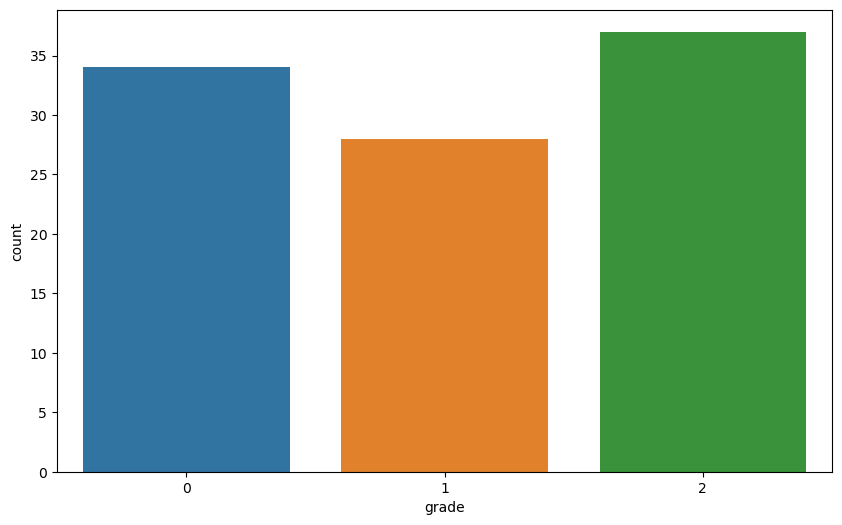

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

*<h3>Data Cleaning<h3>*

In [8]:
df.drop('question_id', axis=1, inplace=True)

In [9]:
df.dropna(inplace=True)

In [10]:
df.drop_duplicates(inplace=True)
print(df['answer'])

0     خلد التاريخ العبد السابق، كأول من أذن في الإسلام.
1     بلال يحكي بصوته قصة نصر الإيمان وأولى نغمات ال...
2                أول مؤذن هو عثمان بن عفان رضي الله عنه
3     في سجلات التاريخ، يُحفر اسم بلال بحروف من ذهب،...
4      قصة بلال بن رباح تجيب: 'هو أول من أذن للمسلمين'!
                            ...                        
94    عمار بن ياسر (رضي الله عنه) هو الصحابي الذي أد...
95    المؤذن الذي نادى بالأذان واقفًا فوق الكعبة كان...
96                       أذن صحابي لأول مرة في الإسلام.
97    أول أذان في تاريخ الإسلام صدح به بلال بن رباح ...
98    الصحابي عمار بن ياسر (رضي الله عنه) كان المؤذن...
Name: answer, Length: 99, dtype: object


*<h3>Data Pre-Preocessing<h3>*

In [11]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

stanza.download('ar')
nlp = stanza.Pipeline('ar')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words if word.upos != 'PUNCT']
    return tokens

df['answer'] = df['answer'].apply(preprocess_text)

2024-01-09 22:53:10 INFO: Downloading default packages for language: ar (Arabic) ...
2024-01-09 22:53:11 INFO: File exists: C:\Users\amine\stanza_resources\ar\default.zip
2024-01-09 22:53:15 INFO: Finished downloading models and saved to C:\Users\amine\stanza_resources.
2024-01-09 22:53:15 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-09 22:53:18 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-01-09 22:53:18 INFO: Using device: cpu
2024-01-09 22:53:18 INFO: Loading: tokenize
2024-01-09 22:53:19 INFO: Loading: mwt
2024-01-09 22:53:19 INFO: Loading: pos
2024-01-09 22:53:20 INFO: Loading: lemma
2024-01-09 22:53:20 INFO: Loading: depparse
2024-01-09 22:53:20 INFO: Loading: ner
2024-01-09 22:53:21 INFO: Done loading processors!


In [12]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['answer'])
sequences = tokenizer.texts_to_sequences(df['answer'])
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences,max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


X = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_sequence_length)

print(sequences)
print(df['answer'])

Y = to_categorical(df['grade'], num_classes=3)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


[[  0   0   0 ...  18   6   7]
 [  0   0   0 ...   2  82  13]
 [  0   0   0 ...   8   4  46]
 ...
 [  0   0   0 ...  73   6   7]
 [  0   0   0 ...   4   9   1]
 [  0   0   0 ...  10 273  26]]
0     [خَلَد, تَارِيخ, العبد, سَابِق, كَأُول, مِن, أ...
1     [بلال, حَكَى, بِ, صُوَّة, هُوَ, قِصَّة, نصر, إ...
2     [أَوَّل, مُؤَذَّن, هُوَ, عثمان, بِن, عفان, رضي...
3     [فِي, سِجِلّ, تَارِيخ, حَفَر, اِسم, بلال, بِ, ...
4     [قِصَّة, بلال, بِن, رباح, أَجَاب, هُوَ, أَوَّل...
                            ...                        
94    [عمار, بِن, ياسر, رضي, الله, عَن, هُوَ, هُوَ, ...
95    [مُؤَذِّن, اَلَّذِي, نَادِي, بِ, أَذَان, وَ, أ...
96      [أَذن, صحابي, لِ, أَوَّل, مَرَّة, فِي, إِسلَام]
97    [أَوَّل, أُذُن, فِي, تَارِيخ, إِسلَام, صَدَّح,...
98    [صَحَابِيّ, عمار, بِن, ياسر, رضي, الله, عَن, ه...
Name: answer, Length: 99, dtype: object


*<h3>build Models<h3>*

*<h4>RNN Model<h4>*

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.2)

def RNN_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)
#EMBEDDING_DIM = 110
rnn_model = RNN_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[reduce_lr])

# Evaluate the RNN model
evaluation_metrics_updated_rnn = rnn_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for RNN:")
for metric_name, metric_value in zip(rnn_model.metrics_names, evaluation_metrics_updated_rnn):
    print(f"{metric_name}: {metric_value}")


Epoch 1/100


2/2 [==============================] - 7s 1s/step - loss: 1.2396 - accuracy: 0.3418 - val_loss: 1.2032 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 106ms/step - loss: 1.2250 - accuracy: 0.3291 - val_loss: 1.2235 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 1.1236 - accuracy: 0.5000
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2/2 [==============================] - 0s 84ms/step - loss: 1.1496 - accuracy: 0.4810 - val_loss: 1.2080 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 136ms/step - loss: 1.0893 - accuracy: 0.4684 - val_loss: 1.2050 - val_accuracy: 0.3500 - lr: 2.0000e-04
Epoch 5/100
2/2 [==============================] - 0s 136ms/step - loss: 1.1575 - accuracy: 0.4937 - val_loss: 1.2031 - val_accuracy: 0.3500 - lr: 2.0000e-04
Epoch 6/100
2/2 [==============================] - 0s 68ms/step -

*<h4>LSTM Model<h4>*

In [14]:
def LSTM_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(LSTM(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#EMBEDDING_DIM = 110
lstm_model = LSTM_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = lstm_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[early_stopping_rnn])


# Evaluate the lstm model
evaluation_metrics_updated_lstm = lstm_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for LSTM:")
for metric_name, metric_value in zip(lstm_model.metrics_names, evaluation_metrics_updated_lstm):
    print(f"{metric_name}: {metric_value}")

    

Epoch 1/100
2/2 [==============================] - 8s 1s/step - loss: 1.2027 - accuracy: 0.3165 - val_loss: 1.1981 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 0s 85ms/step - loss: 1.1477 - accuracy: 0.6329 - val_loss: 1.1957 - val_accuracy: 0.3500
Epoch 3/100
2/2 [==============================] - 0s 105ms/step - loss: 1.0940 - accuracy: 0.7468 - val_loss: 1.1929 - val_accuracy: 0.3500
Epoch 4/100
2/2 [==============================] - 0s 89ms/step - loss: 0.9821 - accuracy: 0.8101 - val_loss: 1.1900 - val_accuracy: 0.3500
Epoch 5/100
2/2 [==============================] - 0s 98ms/step - loss: 0.8217 - accuracy: 0.8354 - val_loss: 1.1868 - val_accuracy: 0.3500
Epoch 6/100
2/2 [==============================] - 0s 107ms/step - loss: 0.5892 - accuracy: 0.9241 - val_loss: 1.1829 - val_accuracy: 0.4000
Epoch 7/100
2/2 [==============================] - 0s 128ms/step - loss: 0.3470 - accuracy: 0.9620 - val_loss: 1.1776 - val_accuracy: 0.6000
Epoch 8/100
2/2 [==

*<h4>TRANSFORMER Model<h4>*

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, density, rate=0.1, l2_reg=0.01):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(density, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(transformer_units):
        x = TransformerBlock(embed_dim, num_heads, density, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
maxlen = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 120
num_heads = 2
density = 3
transformer_units = 4
mlp_units = [128]
dropout_rate = 0.5
num_classes = len(df['grade'].unique())

transformer_model = build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes)


In [17]:
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))
history = transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/30
3/3 [==============================] - 18s 910ms/step - loss: 1.6185 - accuracy: 0.4167 - val_loss: 2.1556 - val_accuracy: 0.1333
Epoch 2/30
3/3 [==============================] - 0s 139ms/step - loss: 1.6443 - accuracy: 0.5000 - val_loss: 1.3530 - val_accuracy: 0.5333
Epoch 3/30
3/3 [==============================] - 0s 93ms/step - loss: 1.5313 - accuracy: 0.4405 - val_loss: 1.3489 - val_accuracy: 0.6667
Epoch 4/30
3/3 [==============================] - 0s 91ms/step - loss: 1.4224 - accuracy: 0.5000 - val_loss: 1.4477 - val_accuracy: 0.5333
Epoch 5/30
3/3 [==============================] - 0s 88ms/step - loss: 1.1548 - accuracy: 0.7381 - val_loss: 1.0106 - val_accuracy: 0.9333
Epoch 6/30
3/3 [==============================] - 0s 104ms/step - loss: 0.9527 - accuracy: 0.8452 - val_loss: 0.9532 - val_accuracy: 0.8667
Epoch 7/30
3/3 [==============================] - 0s 116ms/step - loss: 0.7285 - accuracy: 0.9286 - val_loss: 1.0678 - val_accuracy: 0.8667
Epoch 8/30
3/3 [=====

In [18]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)
print("Evaluation Metrics Transformer:")
for metric_name, metric_value in zip(transformer_model.metrics_names, evaluation_metrics_transformer):
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 99ms/step - loss: 0.1039 - accuracy: 1.0000
Evaluation Metrics Transformer:
loss: 0.10390578210353851
accuracy: 1.0


In [19]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)

predictions = transformer_model.predict(X_test)
print(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Create DataFrame
results_df = pd.DataFrame({"Real": y_true, "Predicted": y_pred})

# Display DataFrame
print("\nReal and Predicted Values:")
print(results_df)


1/1 [==============================] - 1s 1s/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5
   15  12   1  65  50   2  16   6   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0  11   5  15   8   4   9
    1  14   2  21  54 195  27   6   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  27  41  44   3
   13  12  79  31  26  14  42   3  60]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38   5
   39   8   4   9   1  14   2  10  18]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2  22   6  19   7  47
    3   1  11   5  15   8   4   9   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  85 253  28
   24  23 254 255  23  11  16   7   2]
 [  0   0   0   0   0   0   0   0   0   0   0  62  48   7 225  20  29  25
   30  45  21  47   3  13  64  40  89]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 196  20  29  25  30
    3 197 198 199  17  76  13   6   7]
 [  0   0   0   0   0   0   0   0   0   0   0 

In [20]:
# Evaluate RNN model
rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy RNN:", rnn_accuracy)

# Evaluate LSTM model
lstm_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy LSTM:", lstm_accuracy)

# Evaluate Transformer model
transformer_accuracy = transformer_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy Transformer:", transformer_accuracy)



Accuracy RNN: 0.9333333373069763
Accuracy LSTM: 1.0
Accuracy Transformer: 1.0


In [21]:
# Determine the best model
best_model_name, best_model_accuracy = max([('RNN', rnn_accuracy), ('LSTM', lstm_accuracy), ('Transformer', transformer_accuracy)], key=lambda x: x[1])

save_path = './savedModels/q5_model.h5'
# Save the best model
if best_model_name == 'RNN':
    rnn_model.save(save_path)
elif best_model_name == 'LSTM':
    lstm_model.save(save_path)
elif best_model_name == 'Transformer':
    transformer_model.save(save_path)

print(f"The best model ({best_model_name}) with accuracy {best_model_accuracy} has been saved to '{save_path}'")


The best model (LSTM) with accuracy 1.0 has been saved to './savedModels/q5_model.h5'
